In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
import adddeps
from utils.ACfunctions import Cr, Cv, AC
from utils.utils import concat

In [43]:
gamma_ = 0.003;
eps = 3.3e-4;
a = 0.2;

In [30]:
def load(path):
    lines = 900000
    lines = -1
    N = np.fromfile(path, np.int32, count=1, offset=0)[0]
    scalars = ["step", "t", "Omega", "T", "L"]
    data = np.fromfile(path, np.float64, count=lines*(len(scalars)+6*N), offset=4)

    data = data.reshape(-1, len(scalars) + 6 * N)
    data_thermo = data[:, : len(scalars)]
    data_pos = data[:,  len(scalars):].reshape(-1, 6, N)
    thermo = pd.DataFrame(data_thermo, columns=scalars).set_index("t")
    
    return thermo, data_pos[:, :3, :], data_pos[:, 3:, :]

In [44]:
thermo, rs, vs = load(f"/data/biophys/ashmat/LJ-magnetic/dumps/dump5_{7}.bin")


In [5]:
len(thermo)

900000

In [6]:
del rs, vs


In [32]:
thermos = []
for i in tqdm(range(10)):
    
    thermo, rs, vs = load(f"/data/biophys/ashmat/LJ-magnetic/dumps/dump5_{i}.bin")
    del rs, vs
    thermos.append(thermo)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:11:35<00:00, 429.55s/it]


In [33]:
rs.shape

NameError: name 'rs' is not defined

In [56]:
sr_L = concat(thermos, "L").mean(axis=1)[:0.4e6]

In [57]:
slope, _ = np.polyfit(sr_L.index.values, np.log(sr_L.values), 1)
-4*a**2*eps**2/slope

0.0029465924226453454

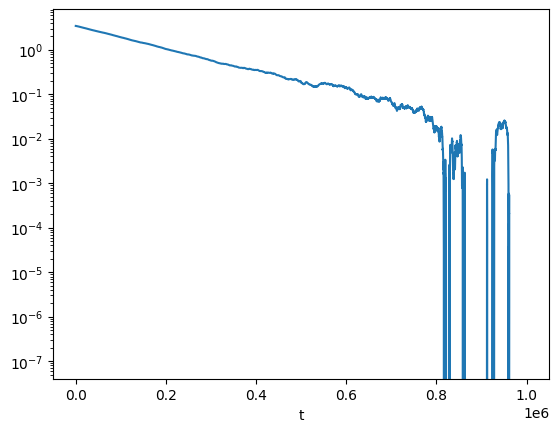

In [58]:
concat(thermos, "L").mean(axis=1)[:1e6].plot()
plt.yscale("log")

In [2]:
path = "/data/biophys/ashmat/LJ-magnetic/dumps/dump5_0.bin"

In [4]:
thermo, rs, vs = load(path)

In [5]:
dt = thermo.index[2]-thermo.index[1]

In [6]:
vc = vs[:, 0, :] + 1j * vs[:, 1, :]

In [7]:
vc.shape

(2000000, 500)

In [128]:
ac = [AC(vc[:,k]) for k in range(vc.shape[-1])]
ac = np.stack(ac, axis=-1)

ac = ac.mean(axis=-1)

In [134]:
ac_time = thermo.index.values

In [136]:
ac_time.shape, ac.shape

((100000,), (100000,))

In [18]:
def _moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def _get_lac(ac):
    period = int(2 * np.pi / a / dt)
    ts = _moving_average(ac_time, period)
    ac = _moving_average(np.abs(ac), period)
    lac = np.log(ac)

    return ts, lac

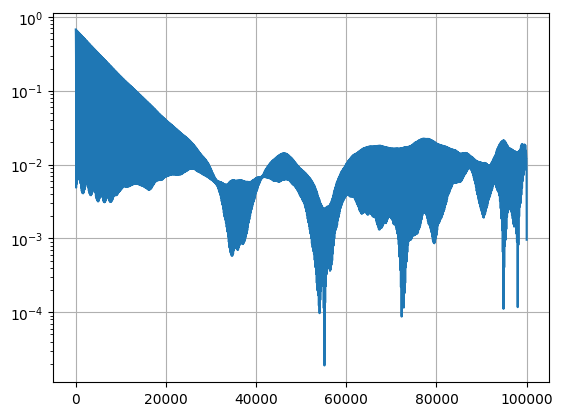

In [129]:
plt.plot(np.abs(ac))
plt.yscale("log")
plt.grid()

In [142]:
x, y = _get_lac(ac)

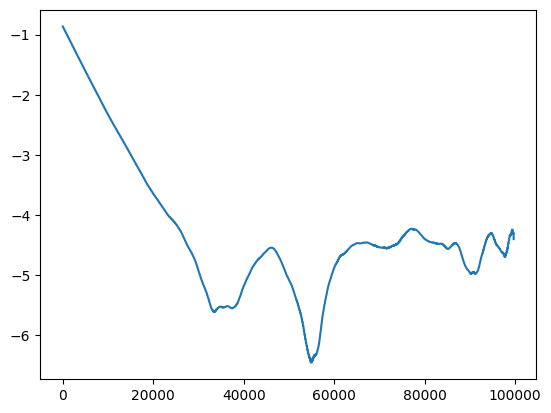

In [144]:
plt.plot(y)

In [145]:
slope, _ = np.polyfit(x[:20000], y[:20000], 1)

In [152]:
def _get_ratio(ts, g, r):
    def f(t, g, r):
        return np.exp(-0.5 * g * t * (1+r))/(1+r)**2 + np.exp(-0.5 * g * t * (1-r))/(1-r)**2

    lac = np.log(f(ts, g, r))
    slope, _ = np.polyfit(ts, lac, 1)
    return slope/g

ts = thermo.iloc[15000:50000].index.values
r = thermo["Omega"].mean() / a
gamma = 0.001
for _ in range(30):
    ratio = _get_ratio(ts, gamma, r)
    gamma = slope / ratio

In [153]:
gamma

0.00278822920596561

In [151]:
slope

-0.0013941146029828044

In [61]:
vs.shape

(10000, 3, 500)

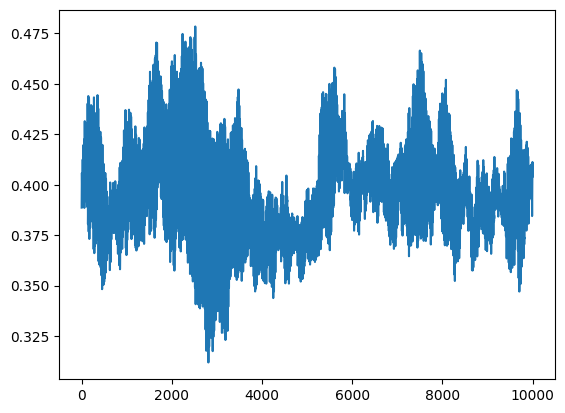

In [62]:
plt.plot(vs[:, 1,:].var(axis=1))

In [63]:
(0.5 * (vs**2).sum(axis=(1,2)))

array([247.95855675, 250.93691323, 251.5591779 , ..., 253.8169244 ,
       251.30056915, 257.24973426])

In [64]:
(0.5 * rs**2 * (np.array([a,a,4*a])**2)[None,:, None]).sum(axis=(1,2))

array([199.82938813, 198.70560545, 197.59318597, ..., 193.62810044,
       191.67690583, 190.63922056])

<Axes: xlabel='t'>

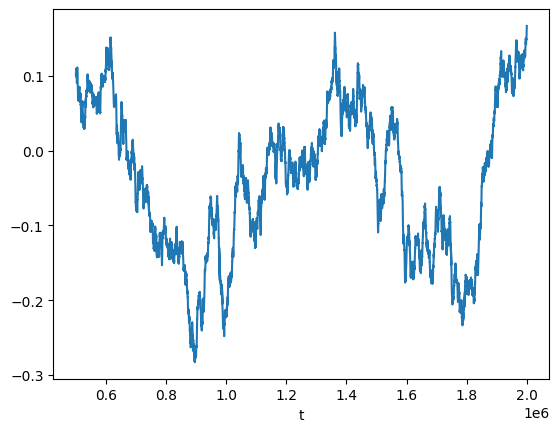

In [56]:
thermo["L"].loc[0.5e6:].plot()
# plt.yscale("log")

In [13]:
sr = thermo["L"].loc[1e4:2e5]

In [17]:
vvvvv

In [5]:
eps**2/gamma_**2

0.009999999999999998

-0.002360272706633902

In [59]:
from tools.gamma_estimator import Engine
from simulator.hdf5IO import Simulation


In [60]:
item = Simulation()
item.record_interval=(thermo.index[1]-thermo.index[0])
item.t = thermo.loc[:0.75e6].index[-1]
item.a = 1/(a * (1+eps))
item.b = 1/(a * (1-eps))


In [61]:
engine = Engine(item, 0, 1000)

In [62]:
engine.vc = vs[:, 0, :] + 1j * vs[:, 1, :]

In [63]:
len(engine.generate_time_points(100, 500))

3704

In [64]:
print("time points:", len(engine.time_points))


time points: 3704


In [65]:
engine.calc_acs()   

In [66]:
def calc_rest(self):
    df = thermo

    for line in self.data:
        t = line["t"]
        l, r = self._get_range(t)
        subdf = df.iloc[l:r+1]
#         print(subdf["L"])
#         return
        line["T"] = (subdf["T"].values).mean()
        line["O"] = subdf["Omega"].values.mean()
        line["L"] = subdf["L"].values.mean()
        
        l, r = self._get_range(t, engine.wide*50)
        subsr = sr_L[l:r+1]
        # print(subdf.index)
        if np.min(subsr) > 0:
            slope, _ = np.polyfit(subsr.index.values, np.log(subsr.values), 1)
            line["g0"] = - 4 * a**2 * eps**2 / slope
        else:
            line["g0"] = np.nan
        
calc_rest(engine)



In [67]:
371720 - 341720

30000

In [68]:
for W in tqdm([5, 15, 30, 50, 100, 200]):
    engine.calc_gamma(W, prefix=f"{W}/")

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:38<00:00, 26.41s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 412.07it/s]


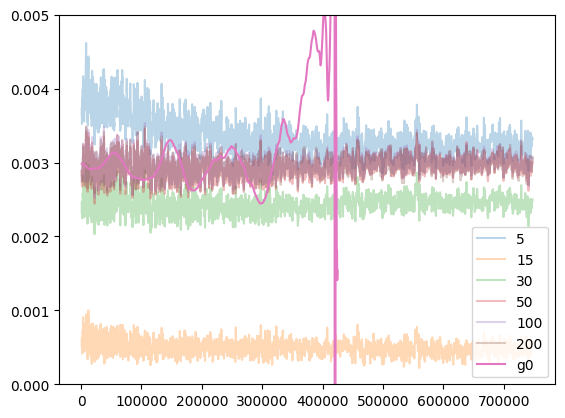

In [69]:
df = pd.DataFrame(engine.data)

for W in tqdm([5, 15, 30, 50, 100, 200]): 
    # W=30
    plt.plot(df["t"], df[f"{W}/g3"], alpha=0.3, label=f"{W}")

plt.plot(df["t"], df[f"g0"], label=f"g0")

plt.ylim(0,5e-3)
plt.legend()

In [58]:
sr = thermo["L"].loc[0.5e6:]

In [66]:
ac = AC(sr.values)
ts = np.arange(len(ac)) * dt


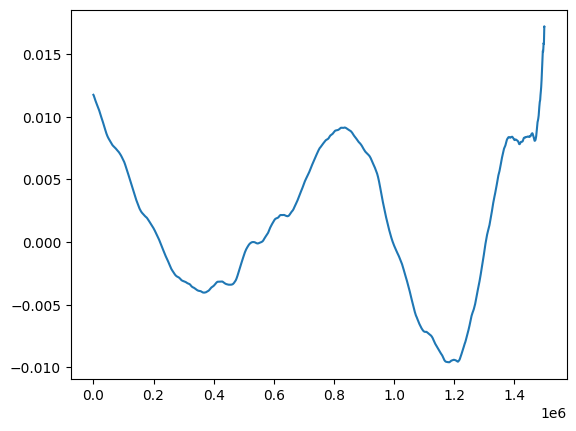

In [67]:
plt.plot(ts, ac)